In [100]:
# Import libraries

import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from math import sqrt, log, pow

In [84]:
# Load input csv (energia and meteo)
df_energia_2021 = pd.read_csv('../input/energia_202109-202112.csv', encoding='latin-1', na_filter=False, names=["data", "hora", "normal", "horario", "autoconsumo", "injecao"], header=0)
df_energia_2022 = pd.read_csv('../input/energia_202201-202212.csv', encoding='latin-1', na_filter=False, names=["data", "hora", "normal", "horario", "autoconsumo", "injecao"], header=0)
df_meteo_2021 = pd.read_csv('../input/meteo_202109-202112.csv', encoding='latin-1', na_values=["", "NaN", ""])
df_meteo_2022 = pd.read_csv('../input/meteo_202201-202212.csv', encoding='latin-1', na_values=["", "NaN", ""])

train_energia = pd.concat([df_energia_2021, df_energia_2022])
train_meteo = pd.concat([df_meteo_2021, df_meteo_2022])

test_energia_X = pd.read_csv('../input/energia_202301-202304.csv', encoding='latin-1')
test_meteo_X = pd.read_csv('../input/meteo_202301-202304.csv', encoding='latin-1')

In [85]:
def remove_utc(s):
    if 'UTC' in s:
        return s[0:-4]
    return s

print(df_energia_2021.info())
print(df_energia_2022.info())
print(train_energia.info())

train_energia = train_energia.rename(columns={"Data":"data", "Hora":"hora", "Normal (kWh)":"normal", "Horário Económico (kWh)":"horario", "Autoconsumo (kWh)":"autoconsumo", "Injeï¿½ï¿½o na rede (kWh)":"injecao"})

print(train_energia.info())

# remove UTC from the end and transform to datetime
train_meteo['dt_iso'] = pd.to_datetime(train_meteo['dt_iso'].map(remove_utc))

# extract date and hour to different columns
train_meteo['data'] = train_meteo['dt_iso'].dt.date
train_meteo['hora'] = train_meteo['dt_iso'].dt.hour

# make date be of type date
train_energia['data'] = pd.to_datetime(train_energia['data']).dt.date

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   data         2256 non-null   object 
 1   hora         2256 non-null   int64  
 2   normal       2256 non-null   float64
 3   horario      2256 non-null   float64
 4   autoconsumo  2256 non-null   float64
 5   injecao      2256 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 105.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   data         8760 non-null   object 
 1   hora         8760 non-null   int64  
 2   normal       8760 non-null   float64
 3   horario      8760 non-null   float64
 4   autoconsumo  8760 non-null   float64
 5   injecao      8760 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory 

In [86]:
train = pd.merge(train_energia, train_meteo, how='outer')

In [87]:
train

,data,hora,normal,horario,autoconsumo,injecao,dt,dt_iso,city_name,temp,...,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,2021-09-29,0,0.0,0.0,0.0,None,1632873600,2021-09-29 00:00:00+00:00,local,13.97,...,11.45,14.04,1027,NaN,NaN,81,1.96,NaN,87,overcast clouds
1,2021-09-29,1,0.0,0.0,0.0,None,1632877200,2021-09-29 01:00:00+00:00,local,13.48,...,13.43,13.90,1028,NaN,NaN,82,1.83,NaN,91,overcast clouds
2,2021-09-29,2,0.0,0.0,0.0,None,1632880800,2021-09-29 02:00:00+00:00,local,12.93,...,12.72,13.43,1027,NaN,NaN,84,1.96,NaN,93,overcast clouds
3,2021-09-29,3,0.0,0.0,0.0,None,1632884400,2021-09-29 03:00:00+00:00,local,12.61,...,10.34,12.93,1027,NaN,NaN,85,1.85,NaN,95,overcast clouds
4,2021-09-29,4,0.0,0.0,0.0,None,1632888000,2021-09-29 04:00:00+00:00,local,12.61,...,9.79,12.93,1027,NaN,NaN,86,1.83,NaN,93,overcast clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11683,2021-09-28,19,NaN,NaN,NaN,NaN,1632855600,2021-09-28 19:00:00+00:00,local,16.77,...,15.72,17.32,1026,NaN,NaN,70,3.11,NaN,55,broken clouds
11684,2021-09-28,20,NaN,NaN,NaN,NaN,1632859200,2021-09-28 20:00:00+00:00,local,15.67,...,14.72,16.21,1027,NaN,NaN,72,2.97,NaN,70,broken clouds
11685,2021-09-28,21,NaN,NaN,NaN,NaN,1632862800,2021-09-28 21:00:00+00:00,local,15.67,...,14.72,15.70,1027,NaN,NaN,72,2.40,NaN,59,broken clouds
11686,2021-09-28,22,NaN,NaN,NaN,NaN,1632866400,2021-09-28 22:00:00+00:00,local,14.52,...,12.72,15.11,1027,NaN,NaN,77,2.11,NaN,37,scattered clouds


In [88]:
'''
Inspect data
'''
print(train.columns)


Index(['data', 'hora', 'normal', 'horario', 'autoconsumo', 'injecao', 'dt',
       'dt_iso', 'city_name', 'temp', 'feels_like', 'temp_min', 'temp_max',
       'pressure', 'sea_level', 'grnd_level', 'humidity', 'wind_speed',
       'rain_1h', 'clouds_all', 'weather_description'],
      dtype='object')


In [89]:

train.head()

,data,hora,normal,horario,autoconsumo,injecao,dt,dt_iso,city_name,temp,...,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,2021-09-29,0,0.0,0.0,0.0,None,1632873600,2021-09-29 00:00:00+00:00,local,13.97,...,11.45,14.04,1027,NaN,NaN,81,1.96,NaN,87,overcast clouds
1,2021-09-29,1,0.0,0.0,0.0,None,1632877200,2021-09-29 01:00:00+00:00,local,13.48,...,13.43,13.90,1028,NaN,NaN,82,1.83,NaN,91,overcast clouds
2,2021-09-29,2,0.0,0.0,0.0,None,1632880800,2021-09-29 02:00:00+00:00,local,12.93,...,12.72,13.43,1027,NaN,NaN,84,1.96,NaN,93,overcast clouds
3,2021-09-29,3,0.0,0.0,0.0,None,1632884400,2021-09-29 03:00:00+00:00,local,12.61,...,10.34,12.93,1027,NaN,NaN,85,1.85,NaN,95,overcast clouds
4,2021-09-29,4,0.0,0.0,0.0,None,1632888000,2021-09-29 04:00:00+00:00,local,12.61,...,9.79,12.93,1027,NaN,NaN,86,1.83,NaN,93,overcast clouds


In [90]:
cols = ["data", "pressure", "humidity"]

## Tratamento da Data

Vou criar novas colunas para dia da semana

In [91]:
train['weekday'] = pd.to_datetime(train['data']).dt.weekday
train['monthday'] = pd.to_datetime(train['data']).dt.day

In [92]:
train[['weekday', 'monthday']]

,weekday,monthday
0,2,29
1,2,29
2,2,29
3,2,29
4,2,29
...,...,...
11683,1,28
11684,1,28
11685,1,28
11686,1,28


In [93]:
#grid = sns.pairplot(train, hue='injecao')
#sns.PairGrid.savefig(grid, fname="pairplot.png")

Nos primeiros dias do mês nas horas entre as 9 e 13 (+/-) temos valores de injecao very high maioritariamente

## Tratamento do pressure

41 valores únicos
0 valores em falta
skewness:  -0.3117837137457725
kurtosis:  0.718909670656481
pressure
1017    889
1018    881
1016    875
1019    775
1015    720
1020    708
1014    670
1021    611
1022    594
1023    563
1013    526
1024    426
1012    388
1025    367
1011    331
1026    315
1027    296
1029    241
1028    212
1010    196
1030    161
1009    159
1031    136
1008    115
1007     67
1032     63
1003     49
1002     49
1006     46
1005     46
1004     38
997      32
998      31
1001     28
1033     26
1000     25
999      15
996       9
995       5
994       3
1034      1
Name: count, dtype: int64


<Axes: >

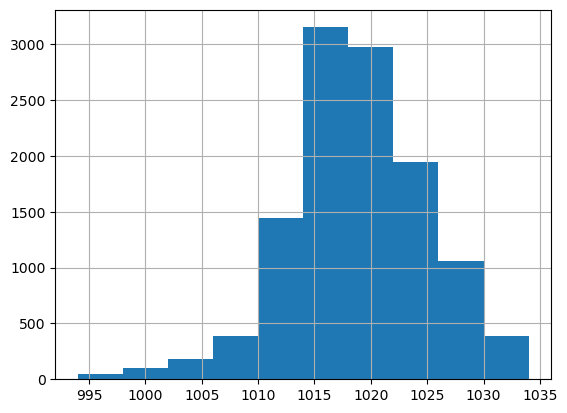

In [94]:
print(train["pressure"].nunique(), "valores únicos")
print(train["pressure"].isnull().sum(), "valores em falta")
print("skewness: ", train["pressure"].skew())
print("kurtosis: ", train["pressure"].kurt())
print(train["pressure"].value_counts())
train["pressure"].hist()

In [95]:
train["pressure"] = preprocessing.normalize([train["pressure"]])[0]

41 valores únicos
0 valores em falta
skewness:  -0.31178371374570507
kurtosis:  0.7189096706564535
pressure
0.009238    889
0.009247    881
0.009229    875
0.009256    775
0.009220    720
0.009265    708
0.009210    670
0.009274    611
0.009283    594
0.009292    563
0.009201    526
0.009301    426
0.009192    388
0.009310    367
0.009183    331
0.009319    315
0.009329    296
0.009347    241
0.009338    212
0.009174    196
0.009356    161
0.009165    159
0.009365    136
0.009156    115
0.009147     67
0.009374     63
0.009111     49
0.009101     49
0.009138     46
0.009129     46
0.009120     38
0.009056     32
0.009065     31
0.009092     28
0.009383     26
0.009083     25
0.009074     15
0.009047      9
0.009038      5
0.009029      3
0.009392      1
Name: count, dtype: int64


<Axes: >

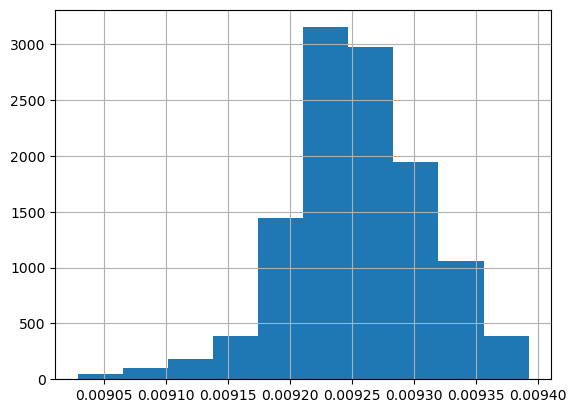

In [96]:
print(train["pressure"].nunique(), "valores únicos")
print(train["pressure"].isnull().sum(), "valores em falta")
print("skewness: ", train["pressure"].skew())
print("kurtosis: ", train["pressure"].kurt())
print(train["pressure"].value_counts())
train["pressure"].hist()

## Tratamento do Humidity

82 valores únicos
0 valores em falta
skewness:  -0.8917871113785469
kurtosis:  0.0661975880927752
humidity
93     751
94     714
92     513
91     445
90     394
      ... 
20       4
99       4
100      2
21       1
19       1
Name: count, Length: 82, dtype: int64
count    11688.000000
mean        76.619011
std         16.157421
min         19.000000
25%         66.000000
50%         81.000000
75%         91.000000
max        100.000000
Name: humidity, dtype: float64


<Axes: >

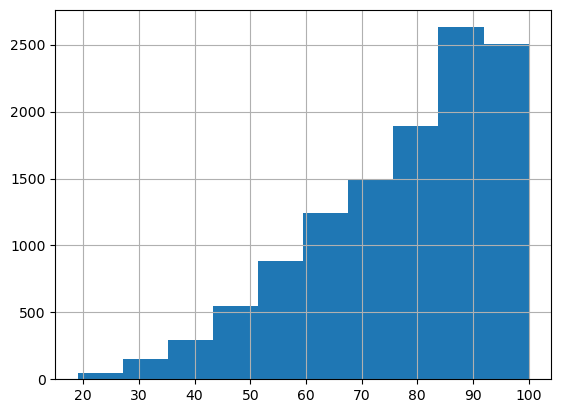

In [97]:
print(train["humidity"].nunique(), "valores únicos")
print(train["humidity"].isnull().sum(), "valores em falta")
print("skewness: ", train["humidity"].skew())
print("kurtosis: ", train["humidity"].kurt())
print(train["humidity"].value_counts())
print(train["humidity"].describe())
train["humidity"].hist()

reflexao - skewness:  0.891787111378305
reflexao - kurtosis:  0.06619758809249587
sqrt + reflexao - skewness:  0.8899766814963544
sqrt + reflexao - kurtosis:  0.061137359926998425
log + reflexao - skewness:  0.8881684251071483
log + reflexao - kurtosis:  0.056092404749943814
reflexao - skewness:  0.0
reflexao - kurtosis:  -1.2271734494380906


<Axes: >

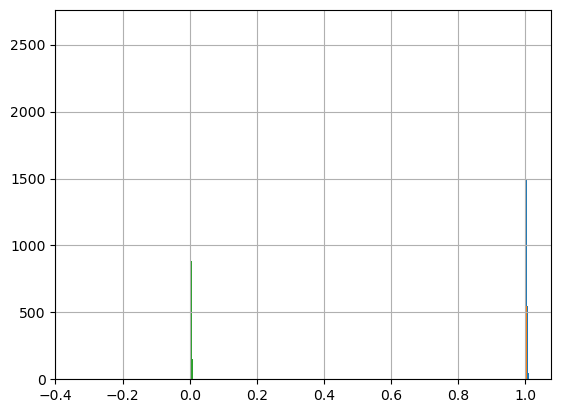

In [146]:
# Reducing skewness
def box_cox(x, _lambda=0.5):
    return (pow(x, _lambda)-1)/_lambda

humidity_reflected = train["humidity"].map(lambda x : train['humidity'].max()+1-x)
#print(humidity_reflected.value_counts())
print("reflexao - skewness: ", humidity_reflected.skew())
print("reflexao - kurtosis: ", humidity_reflected.kurt())
humidity_reflected.hist()
sqrt_humidity_reflected = humidity_reflected.map(sqrt)
print("sqrt + reflexao - skewness: ", sqrt_humidity_reflected.skew())
print("sqrt + reflexao - kurtosis: ", sqrt_humidity_reflected.kurt())
sqrt_humidity_reflected.hist()
log_humidity_reflected = humidity_reflected.map(log)
print("log + reflexao - skewness: ", log_humidity_reflected.skew())
print("log + reflexao - kurtosis: ", log_humidity_reflected.kurt())
log_humidity_reflected.hist()
box_cox_humidity = log_humidity_reflected.map(lambda x : box_cox(x, 1))
#print(box_cox_humidity.value_counts())
print("reflexao - skewness: ", box_cox_humidity.skew())
print("reflexao - kurtosis: ", box_cox_humidity.kurt())
box_cox_humidity.hist()

82 valores únicos
0 valores em falta
skewness:  -0.8917871113785469
kurtosis:  0.0661975880927752
humidity
93     751
94     714
92     513
91     445
90     394
      ... 
20       4
99       4
100      2
21       1
19       1
Name: count, Length: 82, dtype: int64
count    11688.000000
mean        76.619011
std         16.157421
min         19.000000
25%         66.000000
50%         81.000000
75%         91.000000
max        100.000000
Name: humidity, dtype: float64


<Axes: >

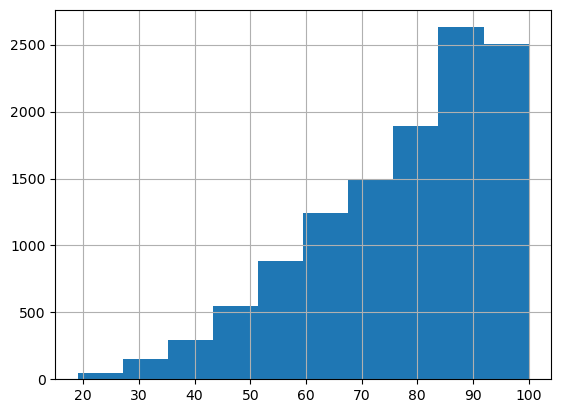

In [99]:
#train['humidity'] = log_humidity_reflected
print(train["humidity"].nunique(), "valores únicos")
print(train["humidity"].isnull().sum(), "valores em falta")
print("skewness: ", train["humidity"].skew())
print("kurtosis: ", train["humidity"].kurt())
print(train["humidity"].value_counts())
print(train["humidity"].describe())
train["humidity"].hist()

In [136]:
# normalizar

train["humidity"] = preprocessing.normalize([train["humidity"]])[0]

82 valores únicos
0 valores em falta
skewness:  -0.891787111378543
kurtosis:  0.06619758809276988
humidity
0.010986    751
0.011104    714
0.010868    513
0.010749    445
0.010631    394
           ... 
0.002363      4
0.011694      4
0.011813      2
0.002481      1
0.002244      1
Name: count, Length: 82, dtype: int64
count    11688.000000
mean         0.009051
std          0.001909
min          0.002244
25%          0.007796
50%          0.009568
75%          0.010749
max          0.011813
Name: humidity, dtype: float64


<Axes: >

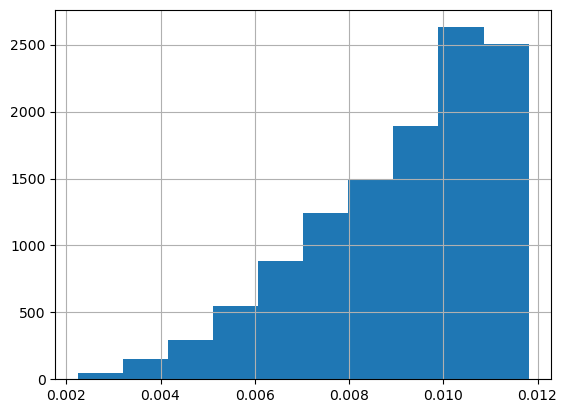

In [137]:
print(train["humidity"].nunique(), "valores únicos")
print(train["humidity"].isnull().sum(), "valores em falta")
print("skewness: ", train["humidity"].skew())
print("kurtosis: ", train["humidity"].kurt())
print(train["humidity"].value_counts())
print(train["humidity"].describe())
train["humidity"].hist()